# Training Convolutional Autoencoders

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tsnecuda import TSNE as TSNE_cuda
import umap
from matplotlib import pyplot as plt
from time import time
import mplcyberpunk as cp
%matplotlib inline
plt.style.use('../dark-custom.mplstyle')

In [2]:
import sys
sys.path.append('..')
from ModelClasses.Autoencoders import ConvolutionalAutoencoder
from Utils import (
    autoencoder_train_loop,
    plot_loss,
    compare_generated_to_original_mnist,
    get_dict_of_latent_spaces,
    compare_latent_spaces,
    zoom_limits
)

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training the Autoencoder

Let's see how the number of channels in encoder affects

In [4]:
DATA_PATH = '../Datasets/data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
mnist_train = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

In [5]:
INPUT_SHAPE = [1, 28, 28]
LEARNING_RATE = 0.002
BATCH_SIZE = 512
NUM_EPOCHS = 25
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

num_filters_list = [2, 8, 16, 32, 64, 128]
kernel_size = 3
stride = 1
latent_space_dim = 2

In [6]:
loss_results = {}
trained_models = {}
model_path = './models/9.2-ConvolutionalAutoencoders/'
for num_filters in num_filters_list:
    architecture = [num_filters, latent_space_dim]
    print(f'{architecture}')
    
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=[num_filters],
        convolutional_kernels=[kernel_size],
        convolutional_strides=[stride],
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[2, 2]


100%|██████████| 25/25 [04:54<00:00, 11.78s/it, loss=0.68] 


[8, 2]


100%|██████████| 25/25 [05:48<00:00, 13.94s/it, loss=0.65] 


[16, 2]


100%|██████████| 25/25 [05:45<00:00, 13.82s/it, loss=0.714]


[32, 2]


100%|██████████| 25/25 [05:55<00:00, 14.22s/it, loss=0.707]


[64, 2]


100%|██████████| 25/25 [05:41<00:00, 13.65s/it, loss=0.709]


[128, 2]


100%|██████████| 25/25 [06:09<00:00, 14.80s/it, loss=0.725]


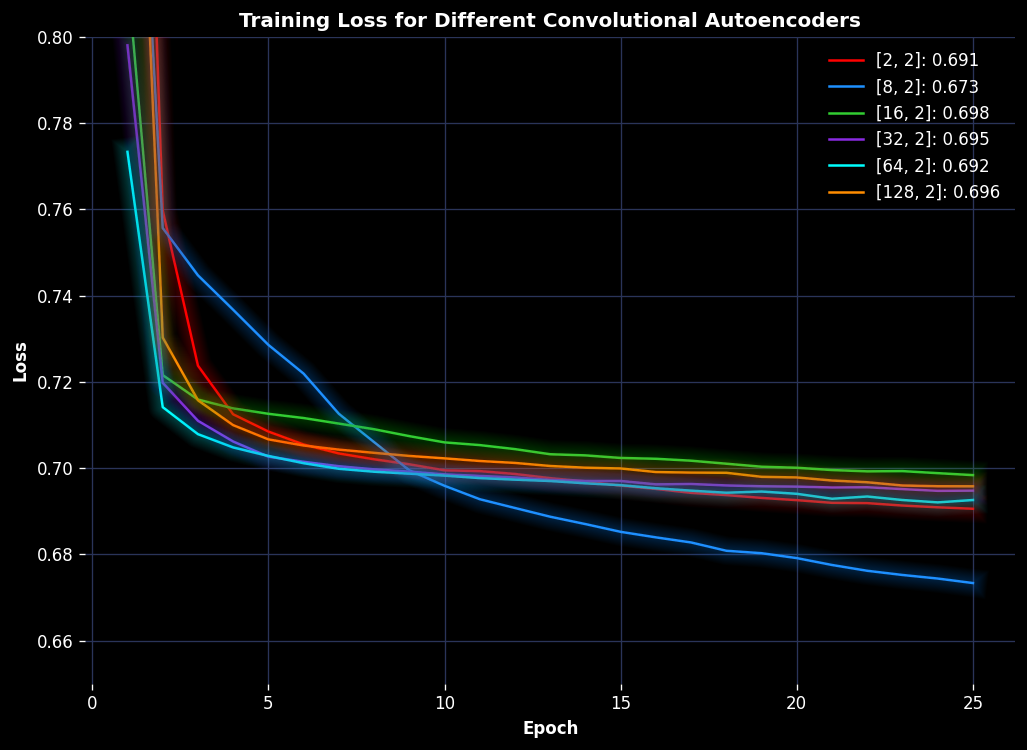

In [7]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.65, 0.8])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=loss_results,
          config_dict=config,
          title=f'Training Loss for Different Convolutional Autoencoders',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.2_image_1.png');

We can see that the bottleneck is likely to be the latent space dimension

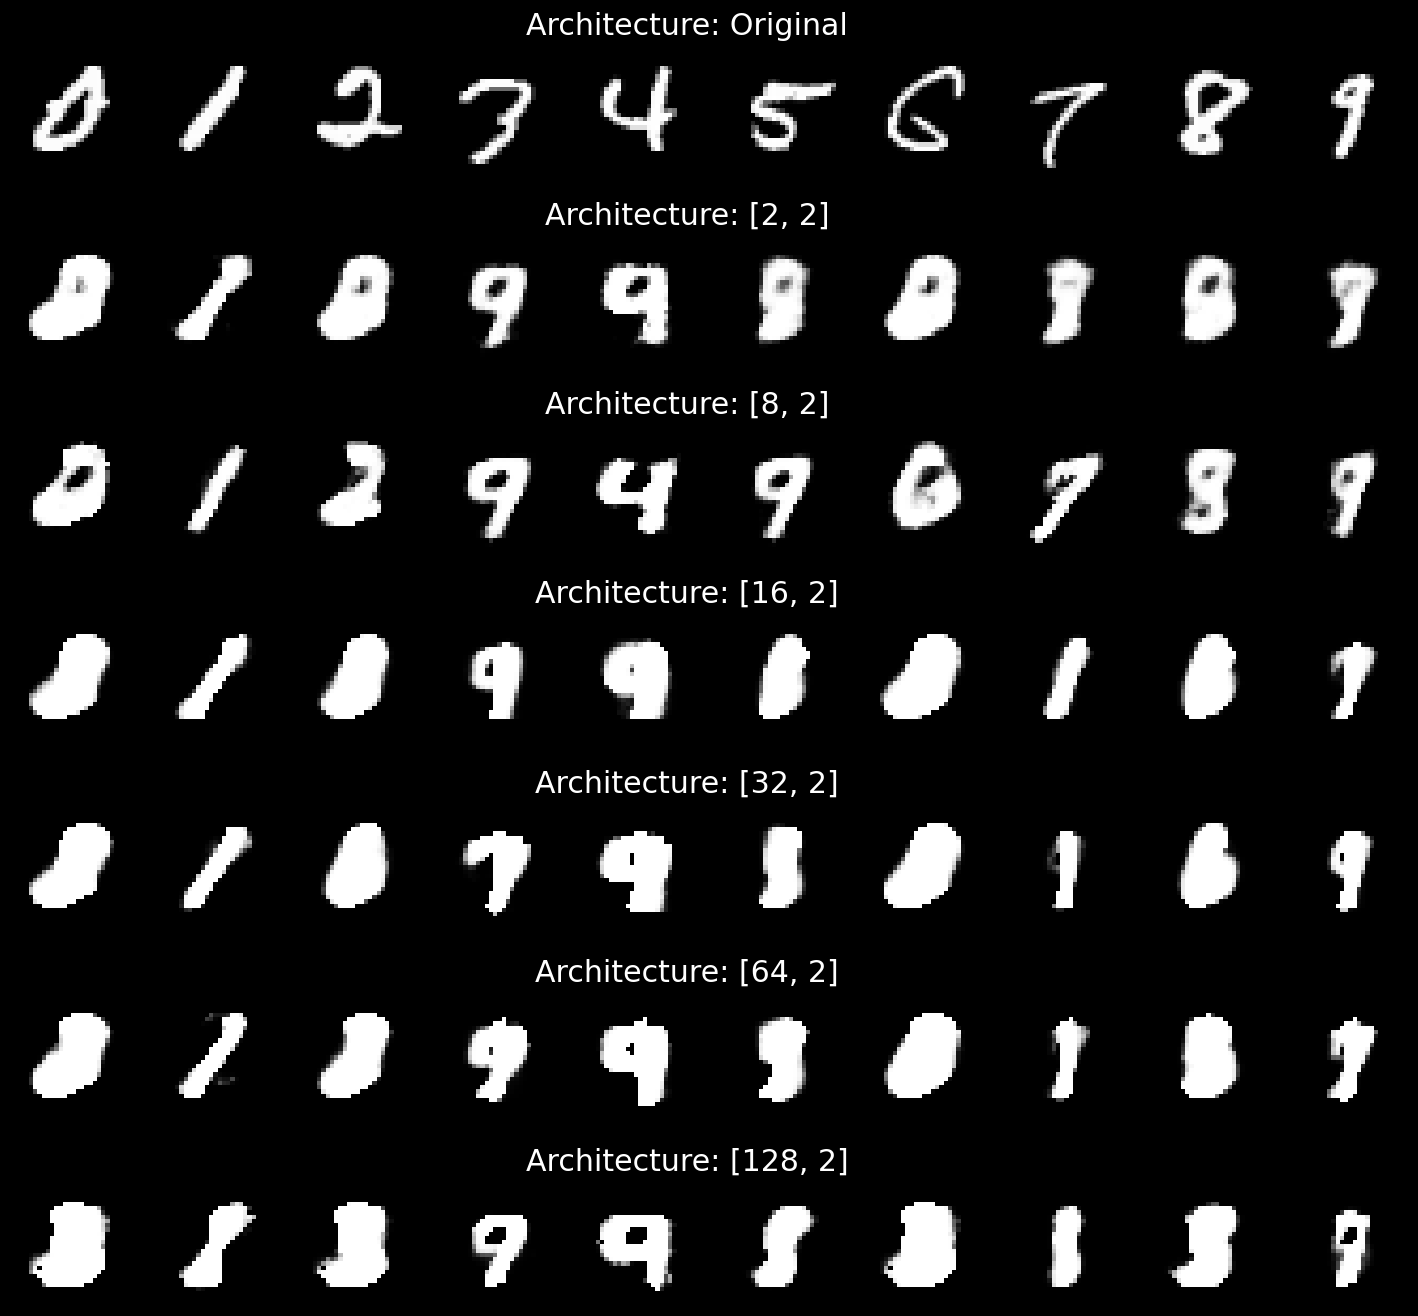

In [8]:
figure, _ = compare_generated_to_original_mnist(trained_models, mnist_test)
figure.savefig('./images/9.2_image_2.png');

In [9]:
latent_space_dict = get_dict_of_latent_spaces(trained_models, mnist_test)

100%|██████████| 40/40 [00:01<00:00, 23.19it/s]


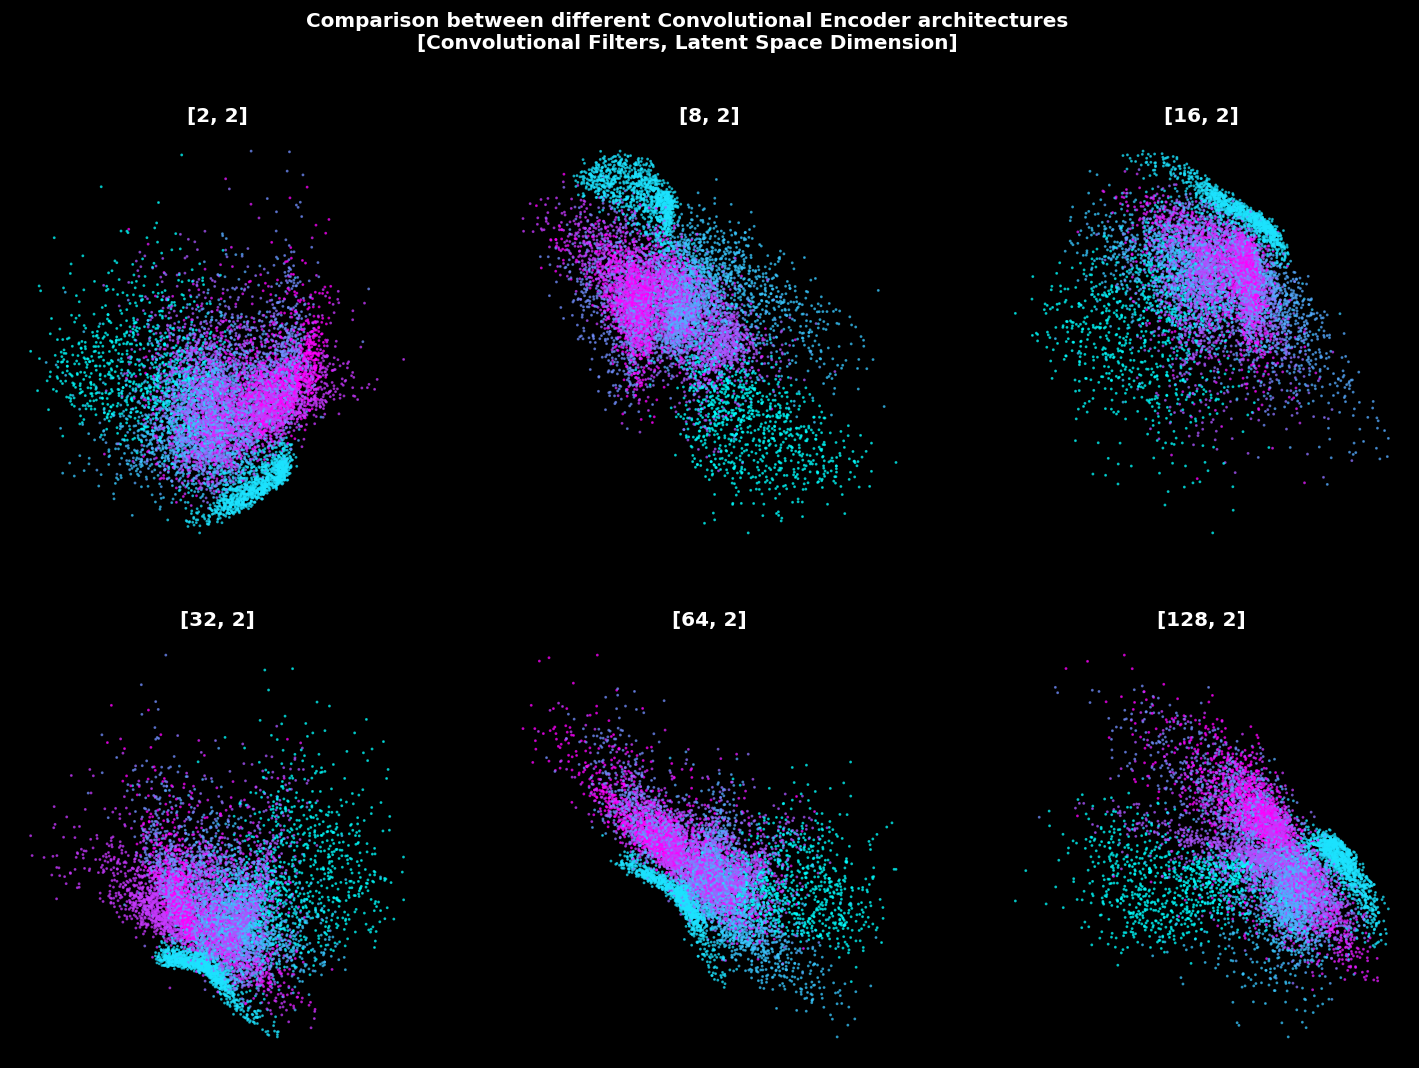

In [10]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
compare_latent_spaces(latent_space_dict, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters, Latent Space Dimension]')
figure.savefig('./images/9.2_image_4.png');

Let's now repeat the calculation for latent space with 3 dimensions

In [11]:
latent_space_dim = 3
for num_filters in num_filters_list:
    architecture = [num_filters, latent_space_dim]
    print(f'{architecture}')
    
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=[num_filters],
        convolutional_kernels=[kernel_size],
        convolutional_strides=[stride],
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[2, 3]


100%|██████████| 25/25 [04:09<00:00,  9.98s/it, loss=0.672]


[8, 3]


100%|██████████| 25/25 [04:33<00:00, 10.94s/it, loss=0.632]


[16, 3]


100%|██████████| 25/25 [04:18<00:00, 10.35s/it, loss=0.665]


[32, 3]


100%|██████████| 25/25 [04:23<00:00, 10.54s/it, loss=0.65] 


[64, 3]


100%|██████████| 25/25 [04:30<00:00, 10.80s/it, loss=0.629]


[128, 3]


100%|██████████| 25/25 [05:06<00:00, 12.27s/it, loss=0.616]


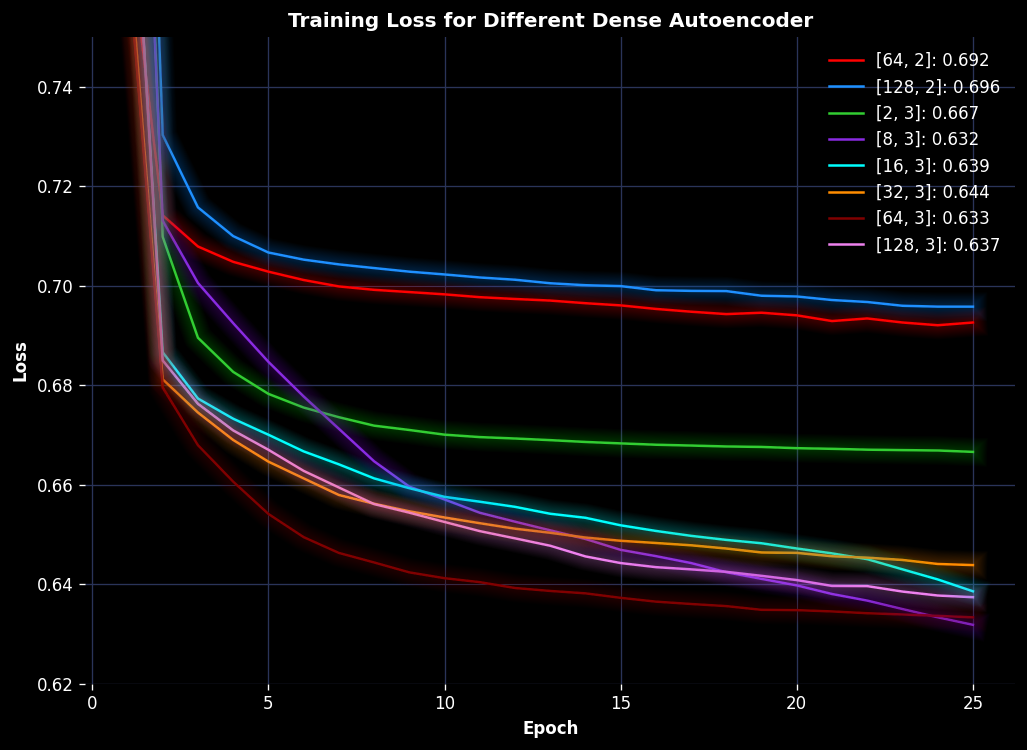

In [12]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.62, 0.75])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=dict(list(loss_results.items())[-8:]),
          config_dict=config,
          title=f'Training Loss for Different Dense Autoencoder',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.2_image_5.png');

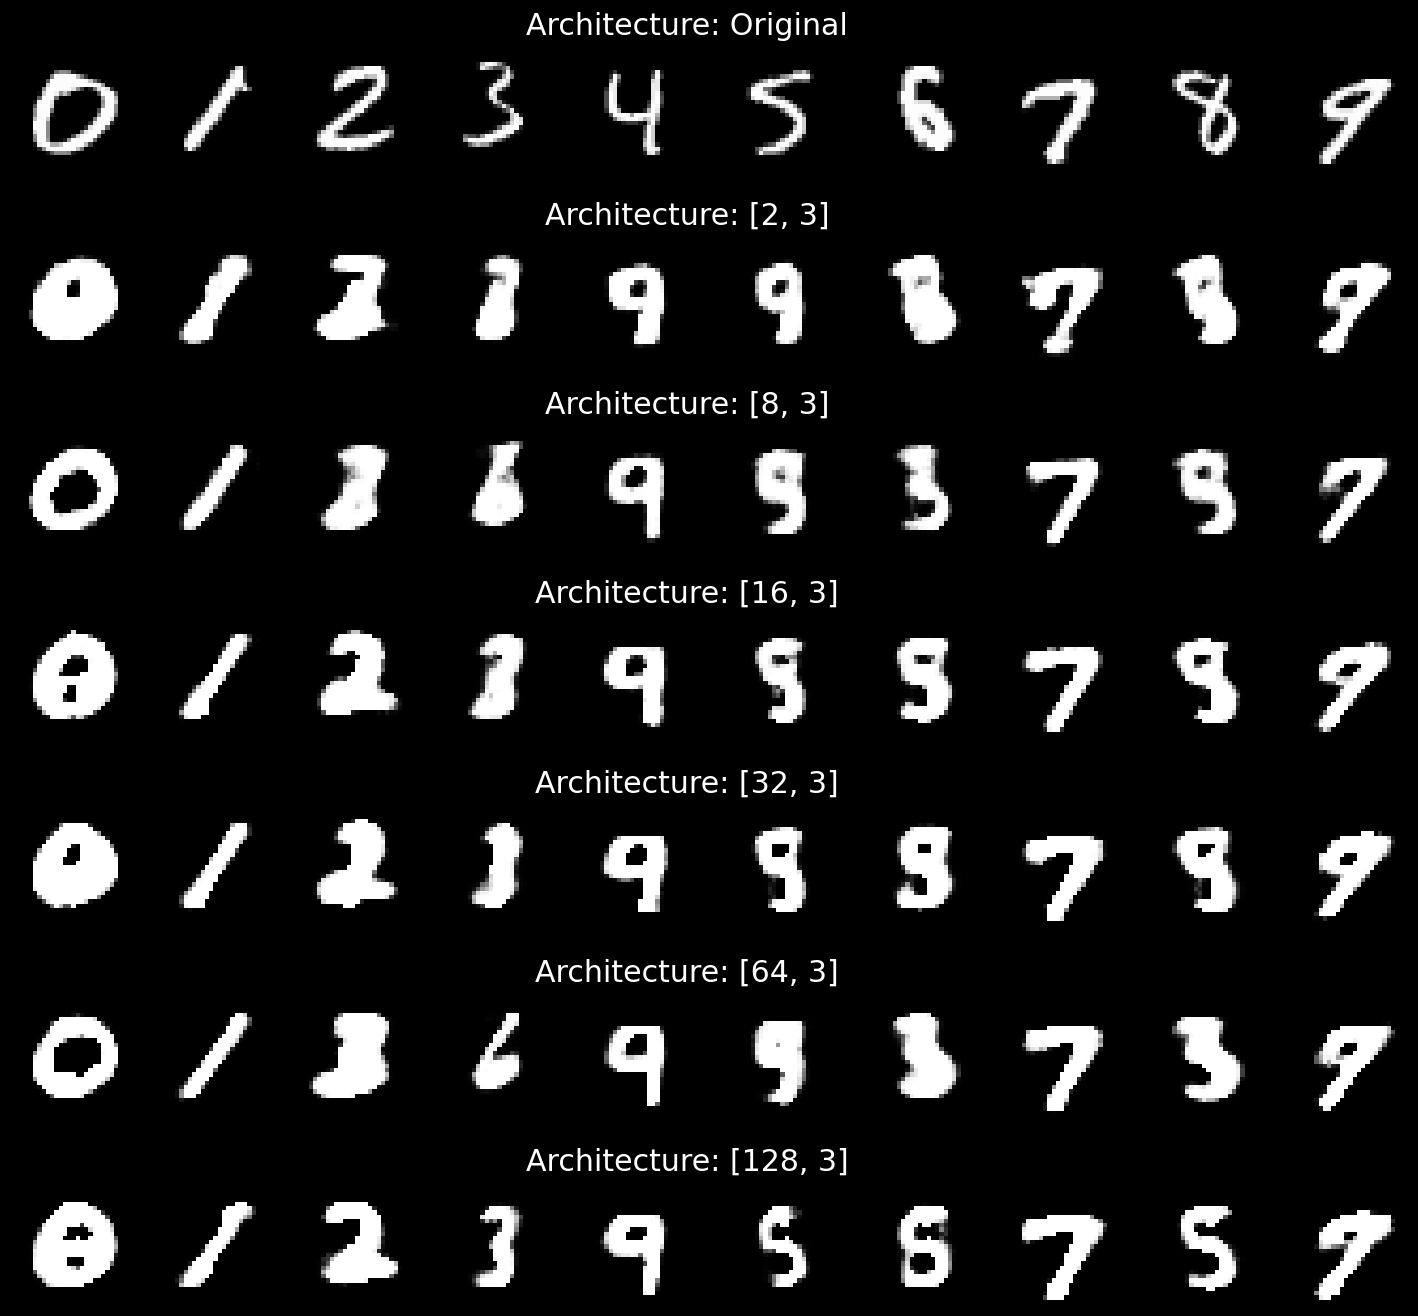

In [13]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if '3]' in name}, 
    mnist_test)
figure.savefig('./images/9.2_image_6.png');

In [14]:
def compare_3d_latent_spaces(latent_space_dict, axes_list,
                             s=0.5, alpha=0.7, cmap='cool', zoom=0.85):
    for i, ((name, space), ax) in enumerate(zip(latent_space_dict.items(), axes_list.ravel()),
                                                  start=1):
        latent_points, labels = space
        ax.scatter(*latent_points, c=labels, s=s, alpha=alpha, cmap=cmap)
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_tick_params(which='major', color='black')
        ax.set(title=name)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlim(zoom_limits(latent_points[0], zoom_factor=zoom))
        ax.set_ylim(zoom_limits(latent_points[1], zoom_factor=zoom))
        ax.set_zlim(zoom_limits(latent_points[2], zoom_factor=zoom))

In [15]:
latent_space_dict = {
    **latent_space_dict,
    **get_dict_of_latent_spaces(
        {name: model for name, model in trained_models.items() if '3]' in name}, 
        mnist_test)
}

100%|██████████| 40/40 [00:01<00:00, 23.04it/s]


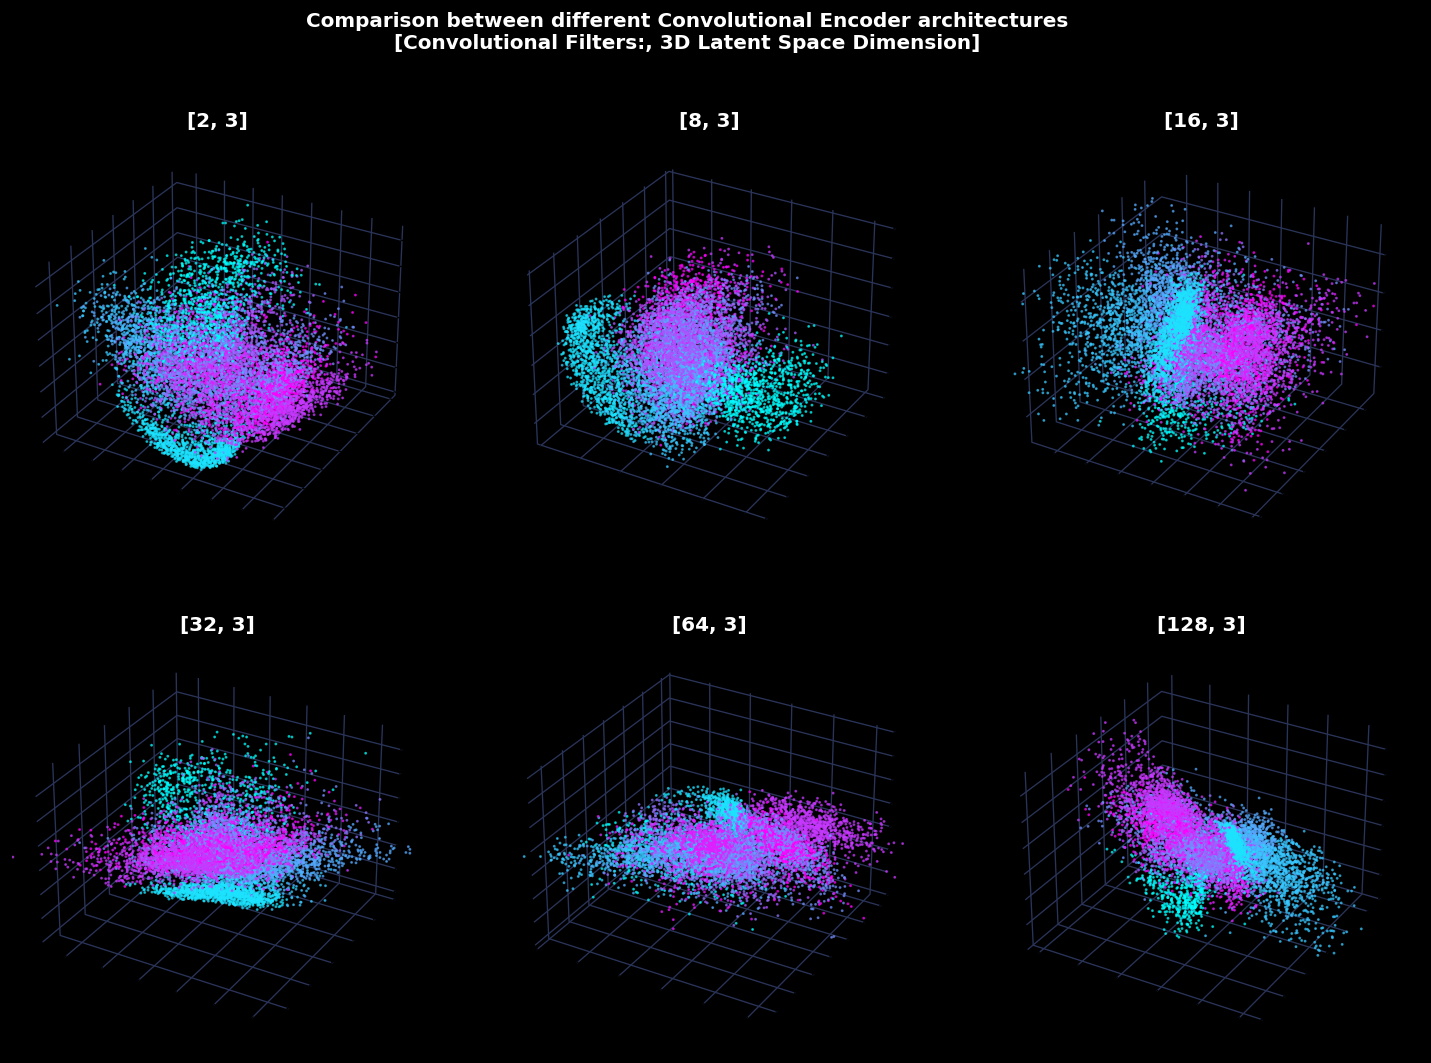

In [16]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if '3]' in name}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters:, 3D Latent Space Dimension]')
figure.savefig('./images/9.2_image_7.png');

Now Let's check how the depth of the network affects performance.

In [17]:
latent_space_dim = 3
num_filters_list = [[64, 64], [32, 32, 32, 32], [32, 64, 64, 32], [32, 64, 64, 64, 64, 32]]
for num_filters in num_filters_list:
    architecture = [*num_filters, latent_space_dim]
    print(f'{architecture}')
    
    n_convs = len(num_filters)
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=num_filters,
        convolutional_kernels=[kernel_size] * n_convs,
        convolutional_strides=[stride] * n_convs,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[64, 64, 3]


100%|██████████| 25/25 [05:12<00:00, 12.51s/it, loss=0.582]


[32, 32, 32, 32, 3]


100%|██████████| 25/25 [05:12<00:00, 12.48s/it, loss=0.6]  


[32, 64, 64, 32, 3]


100%|██████████| 25/25 [06:11<00:00, 14.85s/it, loss=0.614]


[32, 64, 64, 64, 64, 32, 3]


100%|██████████| 25/25 [10:14<00:00, 24.58s/it, loss=0.566]


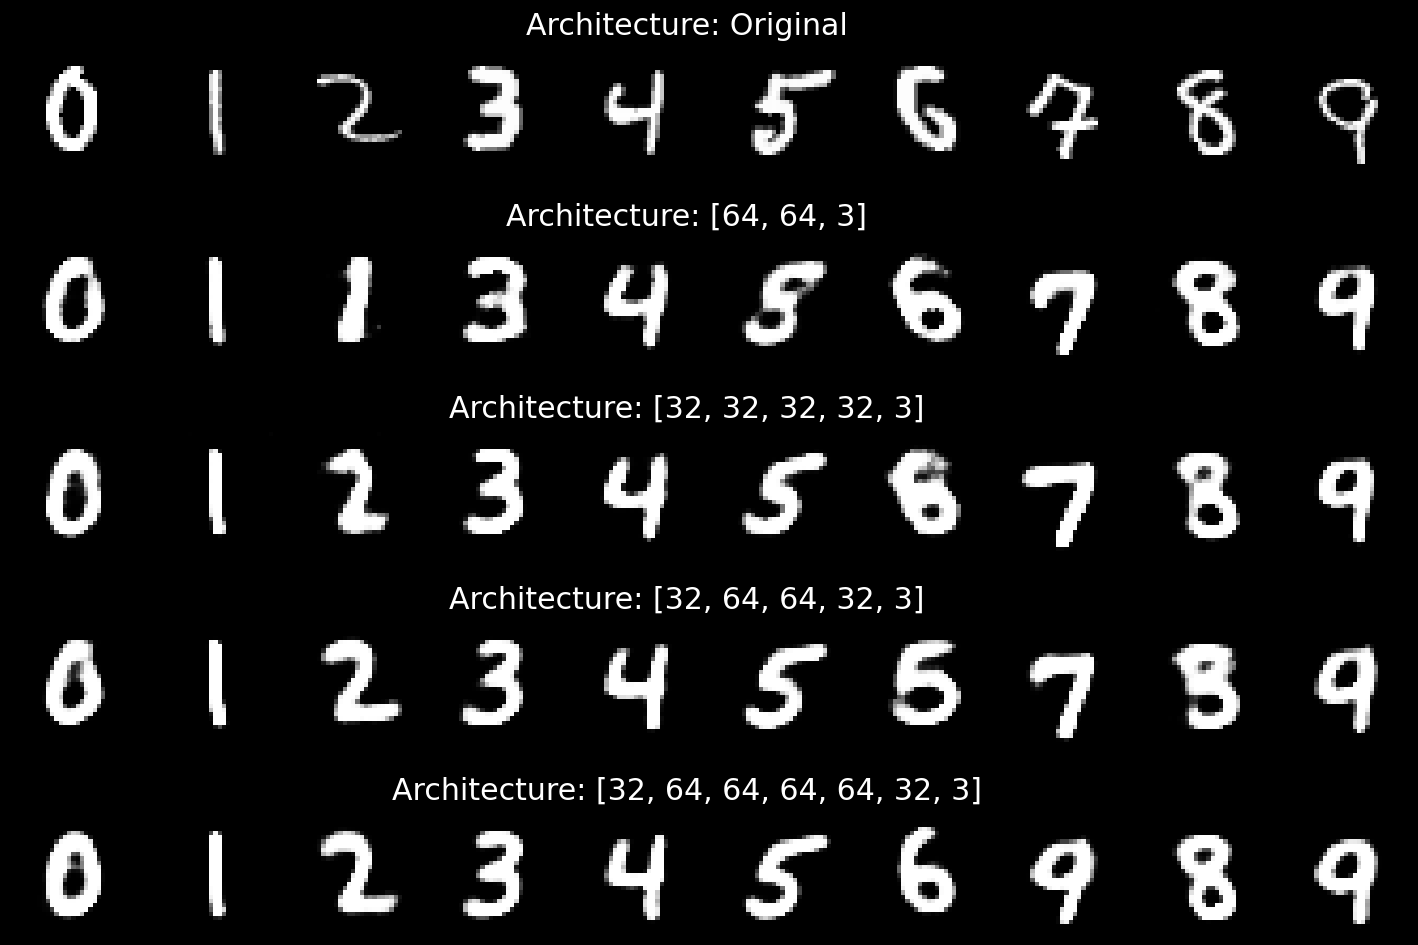

In [18]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if len(eval(name)) > 2}, 
    mnist_test)
figure.savefig('./images/9.2_image_8.png');

Deeper convolutional layers managed to capture more insights and they don't confuse any digits. It is an impressive result considering the fact that the image was compressed to 3 numbers.

In [19]:
latent_space_dict = {
    **latent_space_dict,
    **get_dict_of_latent_spaces(
        {name: space for name, space in latent_space_dict.items() if len(eval(name)) > 2}, 
        mnist_test)
}

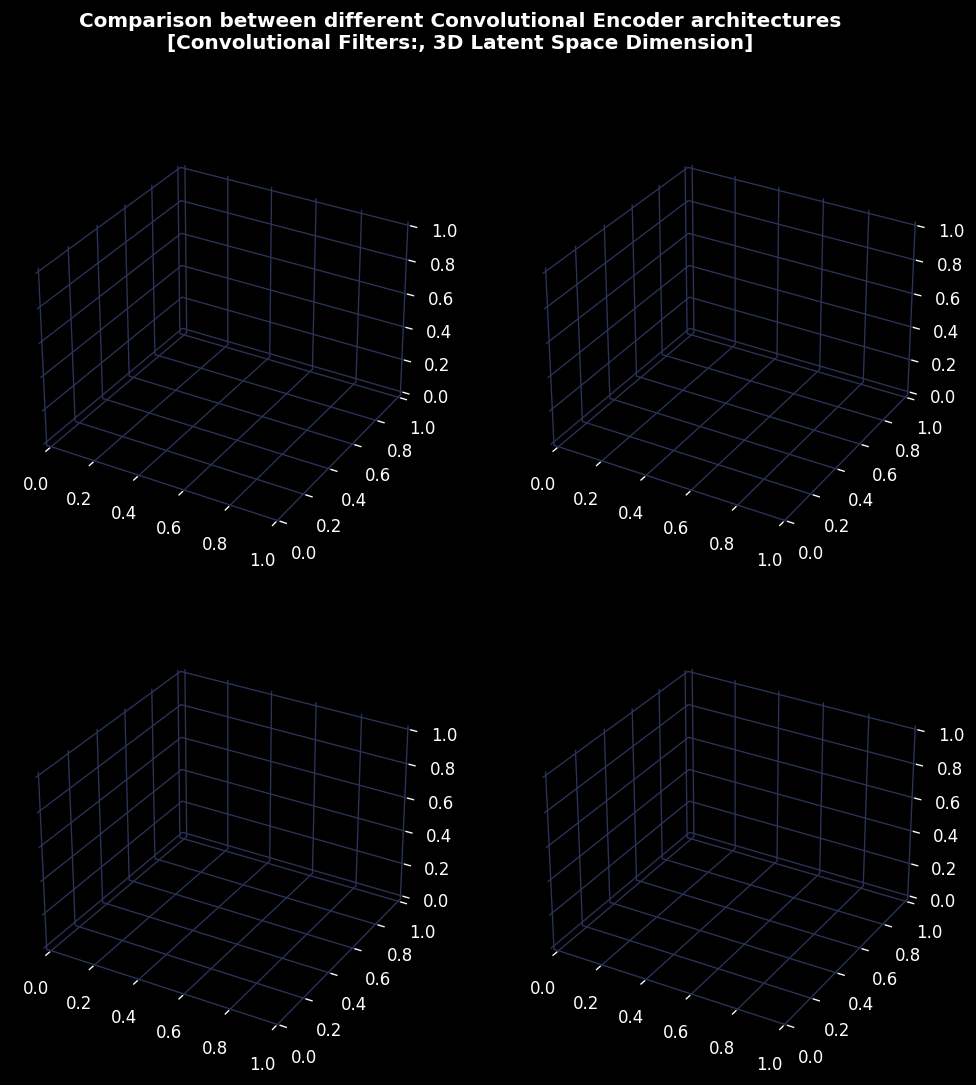

In [20]:
figure, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) > 2}, 
    axes, s=0.2, alpha=0.4)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters:, 3D Latent Space Dimension]')
figure.savefig('./images/9.2_image_9.png');

Let's now take one of the deep architectures and check different latent space dimensions

In [21]:
latent_space_dim_list = [4, 16, 32, 64]
num_filters = [32, 64, 64, 32]
for latent_space_dim in latent_space_dim_list:
    architecture = [*num_filters, latent_space_dim]
    print(f'{architecture}')
    
    n_convs = len(num_filters)
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=num_filters,
        convolutional_kernels=[kernel_size] * n_convs,
        convolutional_strides=[stride] * n_convs,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[32, 64, 64, 32, 4]


100%|██████████| 25/25 [06:11<00:00, 14.85s/it, loss=0.543]


[32, 64, 64, 32, 16]


100%|██████████| 25/25 [06:11<00:00, 14.87s/it, loss=0.465]


[32, 64, 64, 32, 32]


100%|██████████| 25/25 [06:12<00:00, 14.91s/it, loss=0.467]


[32, 64, 64, 32, 64]


100%|██████████| 25/25 [06:15<00:00, 15.01s/it, loss=0.453]


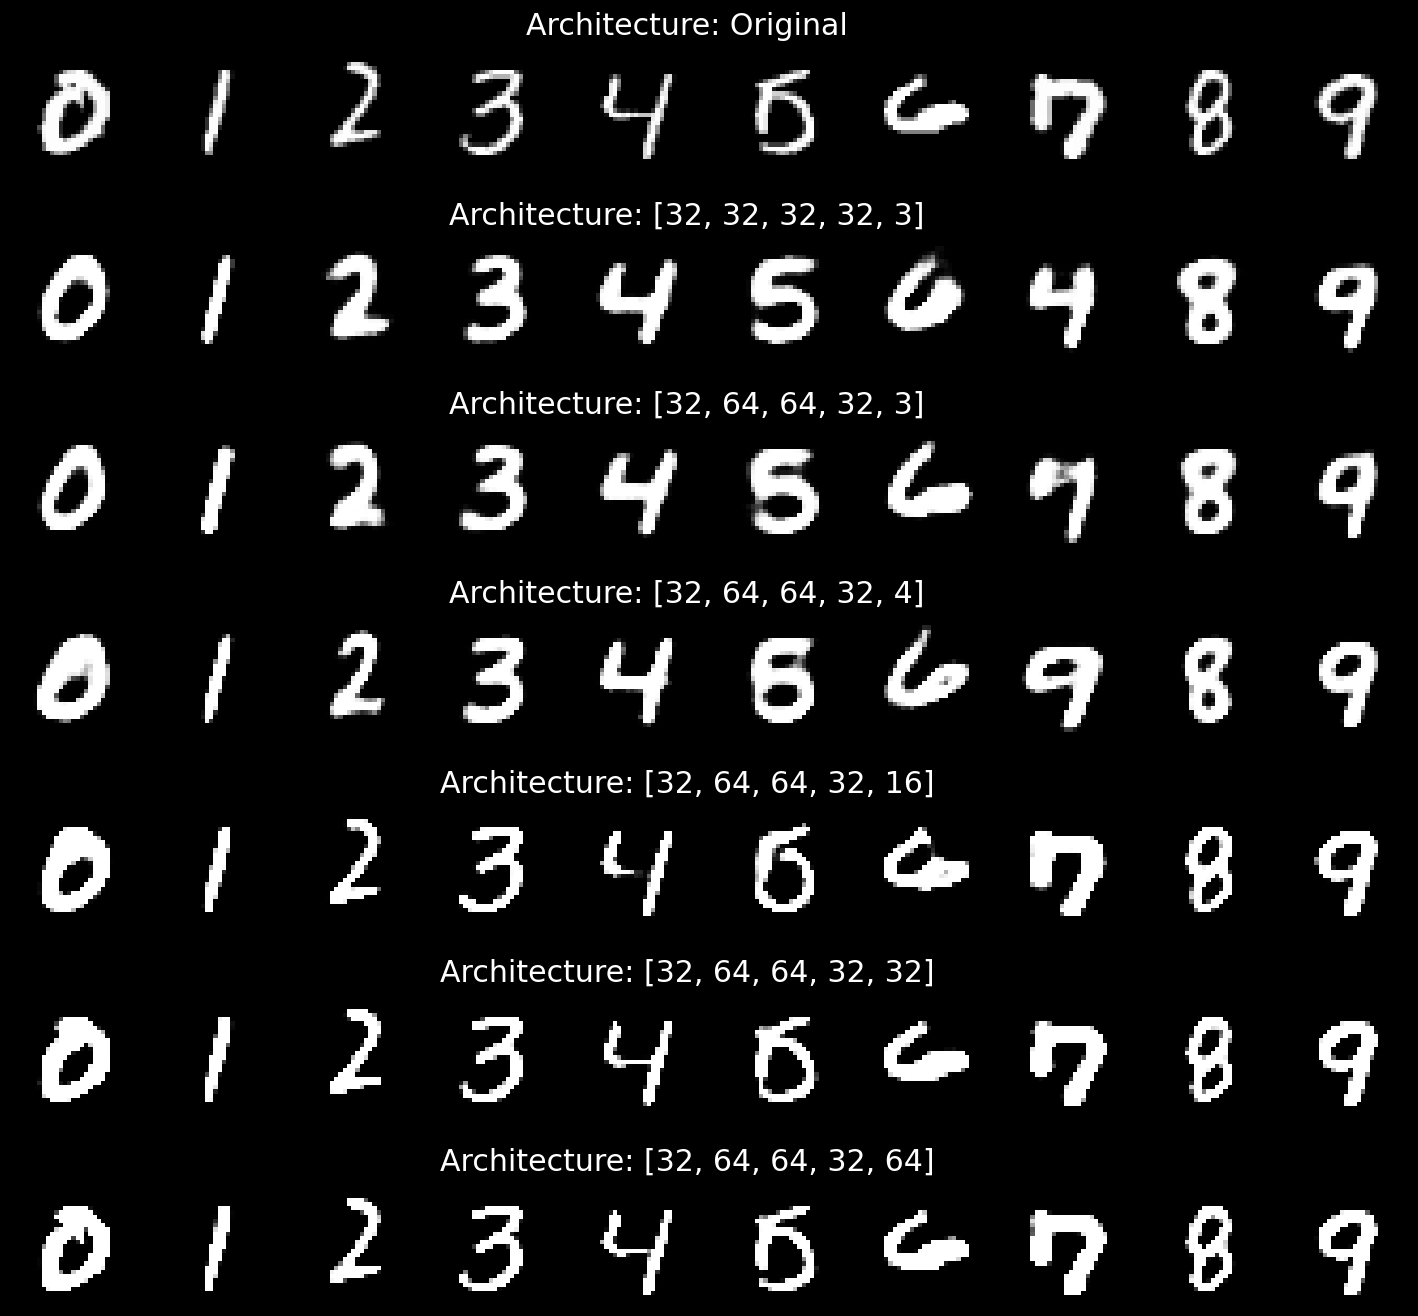

In [22]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
    mnist_test)
figure.savefig('./images/9.2_image_10.png');

In [23]:
def dataset_subset(dataset, n_samples):
    return Subset(dataset, torch.randperm(len(dataset))[:n_samples])

def reduce_dimensions(latent_space, reduced_dim=2, method='PCA', **method_params):
    start = time()
    match method.upper():
        case 'PCA':
            reduction = PCA(n_components=reduced_dim, **method_params)
        case 'TSNE':
            reduction = TSNE(n_components=reduced_dim, **method_params)
        # imcompatible with python 3.12
        # case 'TSNE_CUDA':
        #     reduction = TSNE_cuda(n_components=reduced_dim, **method_params)
        case 'UMAP':
            reduction = umap.UMAP(n_components=reduced_dim, **method_params)
        case _:
            return None
    result = reduction.fit_transform(latent_space)
    total_time = time() - start
    return result, total_time

def reduce_dimensions_of_dict(latent_space_dict, 
                              reduced_dim=2, method='PCA', **method_params):
    reduced_dim_dict = {}
    for name, (latent_space, latent_space_label) in latent_space_dict.items():
        result, result_time = reduce_dimensions(
            latent_space.T, reduced_dim=reduced_dim, method=method, **method_params)
        reduced_dim_dict[name] = (result.T, latent_space_label)
        print(f'Reduced for {name}, time taken: {result_time:.3f} seconds.')
    return reduced_dim_dict

In [24]:
mnist_test_subset = dataset_subset(mnist_test, n_samples=1000)
len(mnist_test_subset)

1000

Let's check how much running TSNE on GPU can improve performance

In [25]:
projected_dim = 2
method = 'TSNE'
method_kwargs = {}
latent_space_dict = {
    **latent_space_dict,
    **reduce_dimensions_of_dict(
        get_dict_of_latent_spaces(
            {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
            mnist_test),
        reduced_dim=projected_dim, method=method, **method_kwargs
    )
}

100%|██████████| 40/40 [00:02<00:00, 19.22it/s]


Reduced for [32, 32, 32, 32, 3], time taken: 28.307 seconds.
Reduced for [32, 64, 64, 32, 3], time taken: 28.476 seconds.
Reduced for [32, 64, 64, 32, 4], time taken: 28.528 seconds.
Reduced for [32, 64, 64, 32, 16], time taken: 30.922 seconds.
Reduced for [32, 64, 64, 32, 32], time taken: 31.014 seconds.
Reduced for [32, 64, 64, 32, 64], time taken: 31.284 seconds.


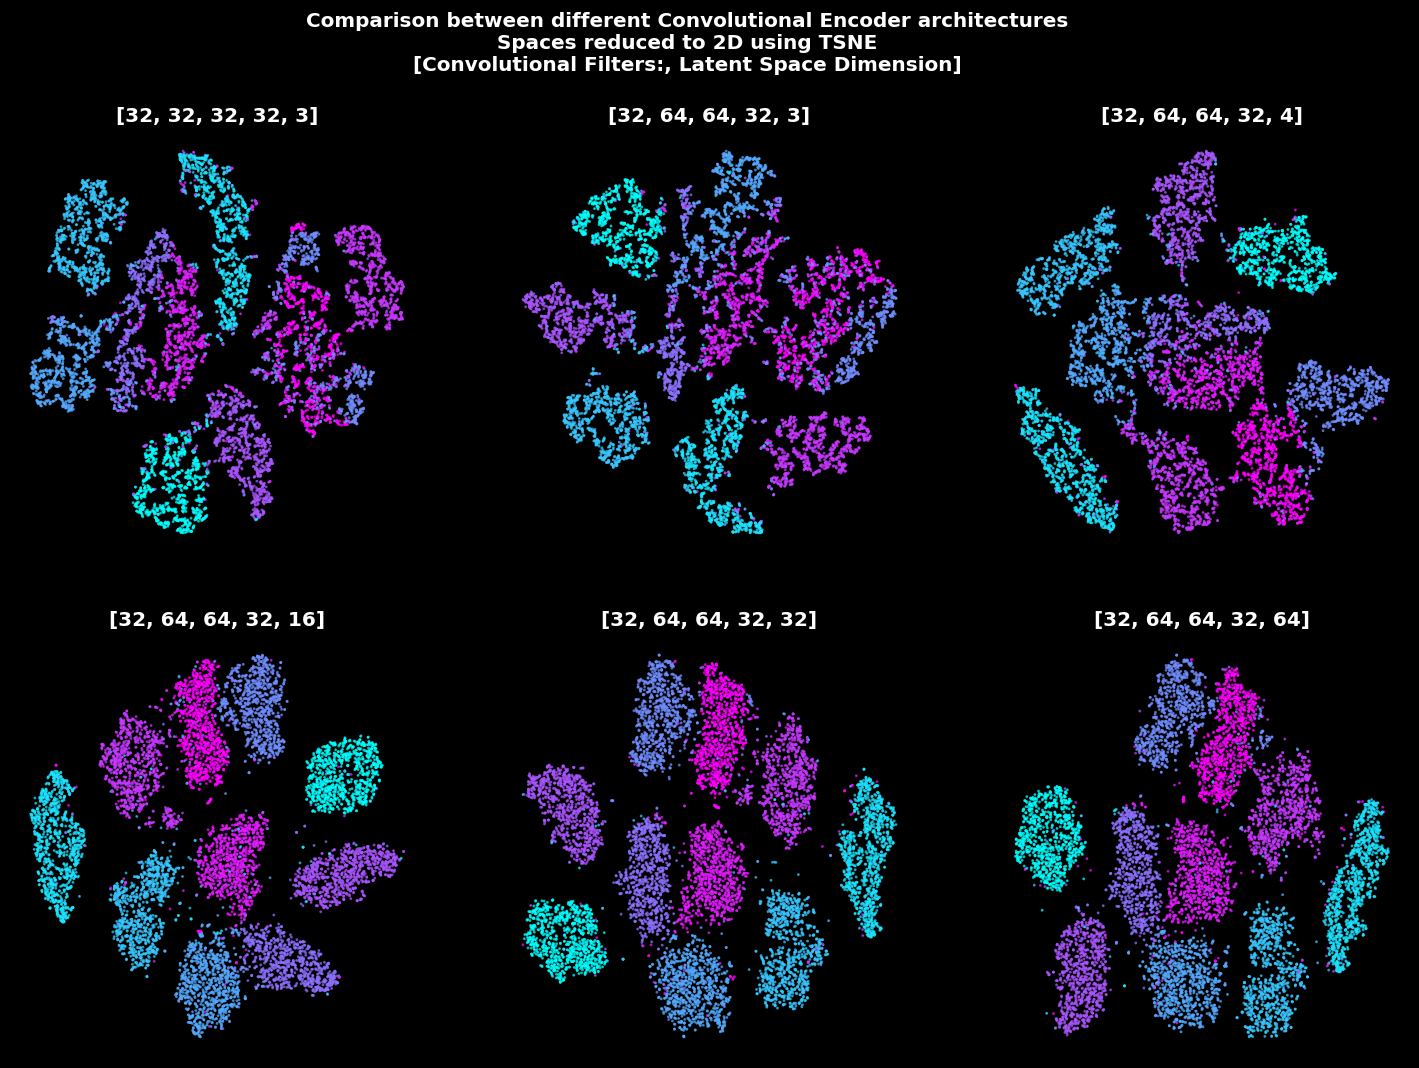

In [26]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
compare_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) == 5}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'Spaces reduced to {projected_dim}D using {method}\n'
                f'[Convolutional Filters:, Latent Space Dimension]')
figure.savefig('./images/9.2_image_10.png');

Let's compare it to UMAP

100%|██████████| 40/40 [00:02<00:00, 19.52it/s]
C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 32, 32, 32, 3], time taken: 19.791 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 3], time taken: 1.933 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 4], time taken: 1.968 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 16], time taken: 2.116 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 32], time taken: 2.132 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 64], time taken: 2.139 seconds.


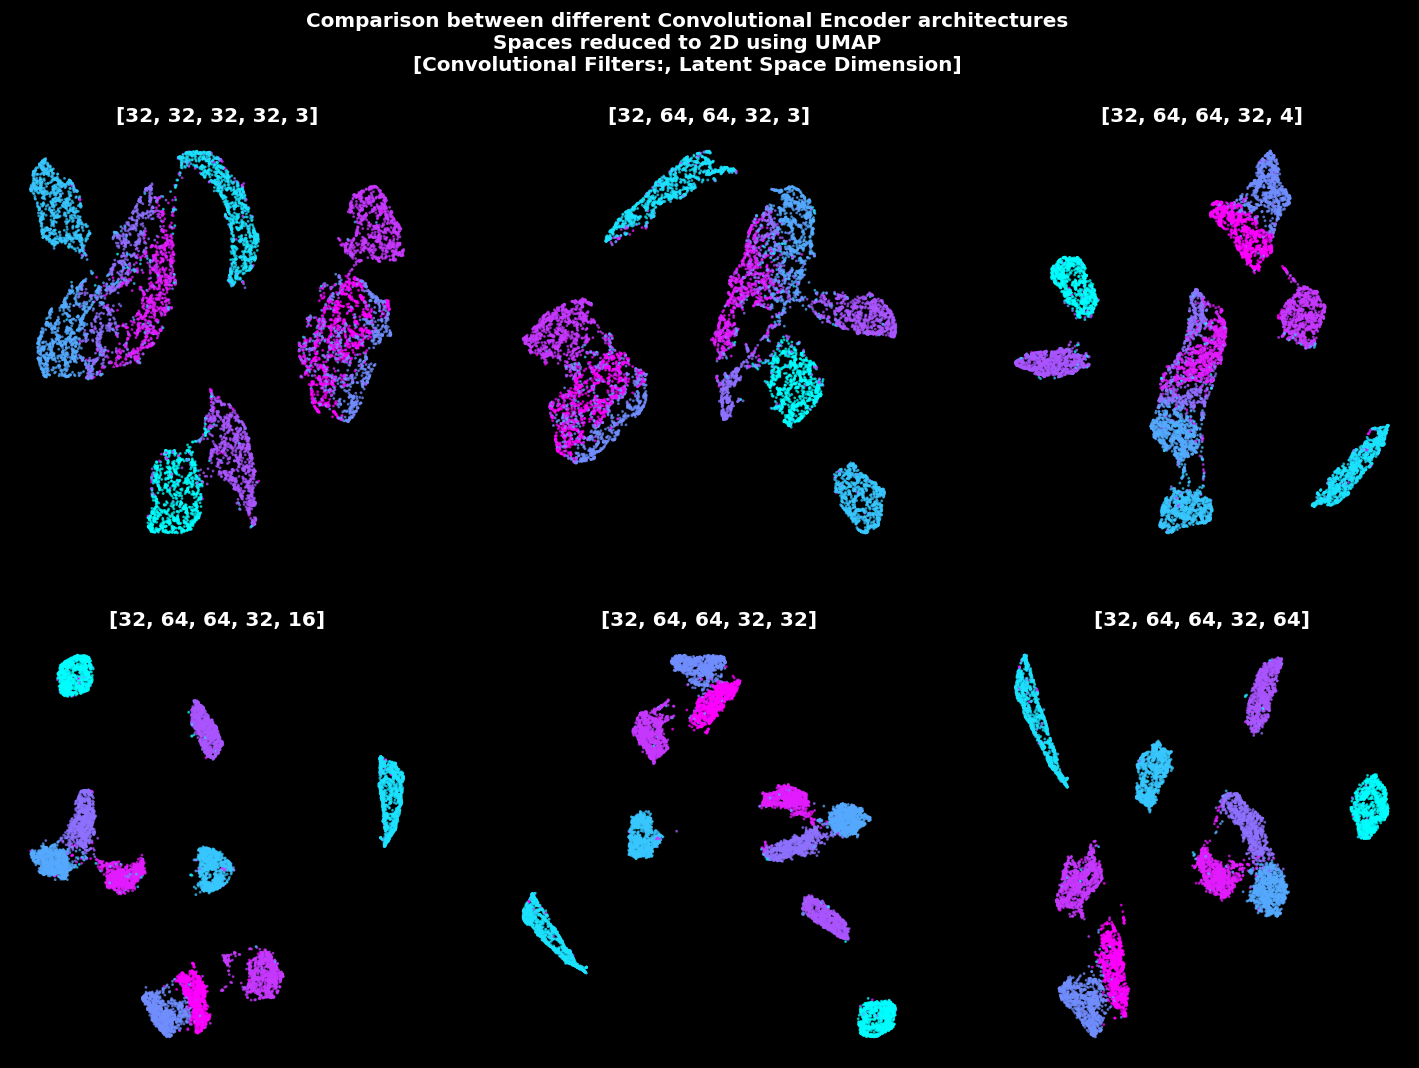

In [27]:
projected_dim = 2
method = 'UMAP'
method_kwargs = {}
latent_space_dict = {
    **latent_space_dict,
    **reduce_dimensions_of_dict(
        get_dict_of_latent_spaces(
            {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
            mnist_test),
        reduced_dim=projected_dim, method=method, **method_kwargs
    )
}
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
compare_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) == 5}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'Spaces reduced to {projected_dim}D using {method}\n'
                f'[Convolutional Filters:, Latent Space Dimension]')
figure.savefig('./images/9.2_image_11.png');

Let's do the same with 3D TSNE

In [28]:
projected_dim = 3
method = 'TSNE'
method_kwargs = {}
latent_space_dict = {
    **latent_space_dict,
    **reduce_dimensions_of_dict(
        get_dict_of_latent_spaces(
            {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
            mnist_test),
        reduced_dim=projected_dim, method=method, **method_kwargs
    )
}

100%|██████████| 40/40 [00:02<00:00, 18.49it/s]


Reduced for [32, 32, 32, 32, 3], time taken: 87.830 seconds.
Reduced for [32, 64, 64, 32, 3], time taken: 82.369 seconds.
Reduced for [32, 64, 64, 32, 4], time taken: 76.272 seconds.
Reduced for [32, 64, 64, 32, 16], time taken: 81.326 seconds.
Reduced for [32, 64, 64, 32, 32], time taken: 84.722 seconds.
Reduced for [32, 64, 64, 32, 64], time taken: 85.789 seconds.


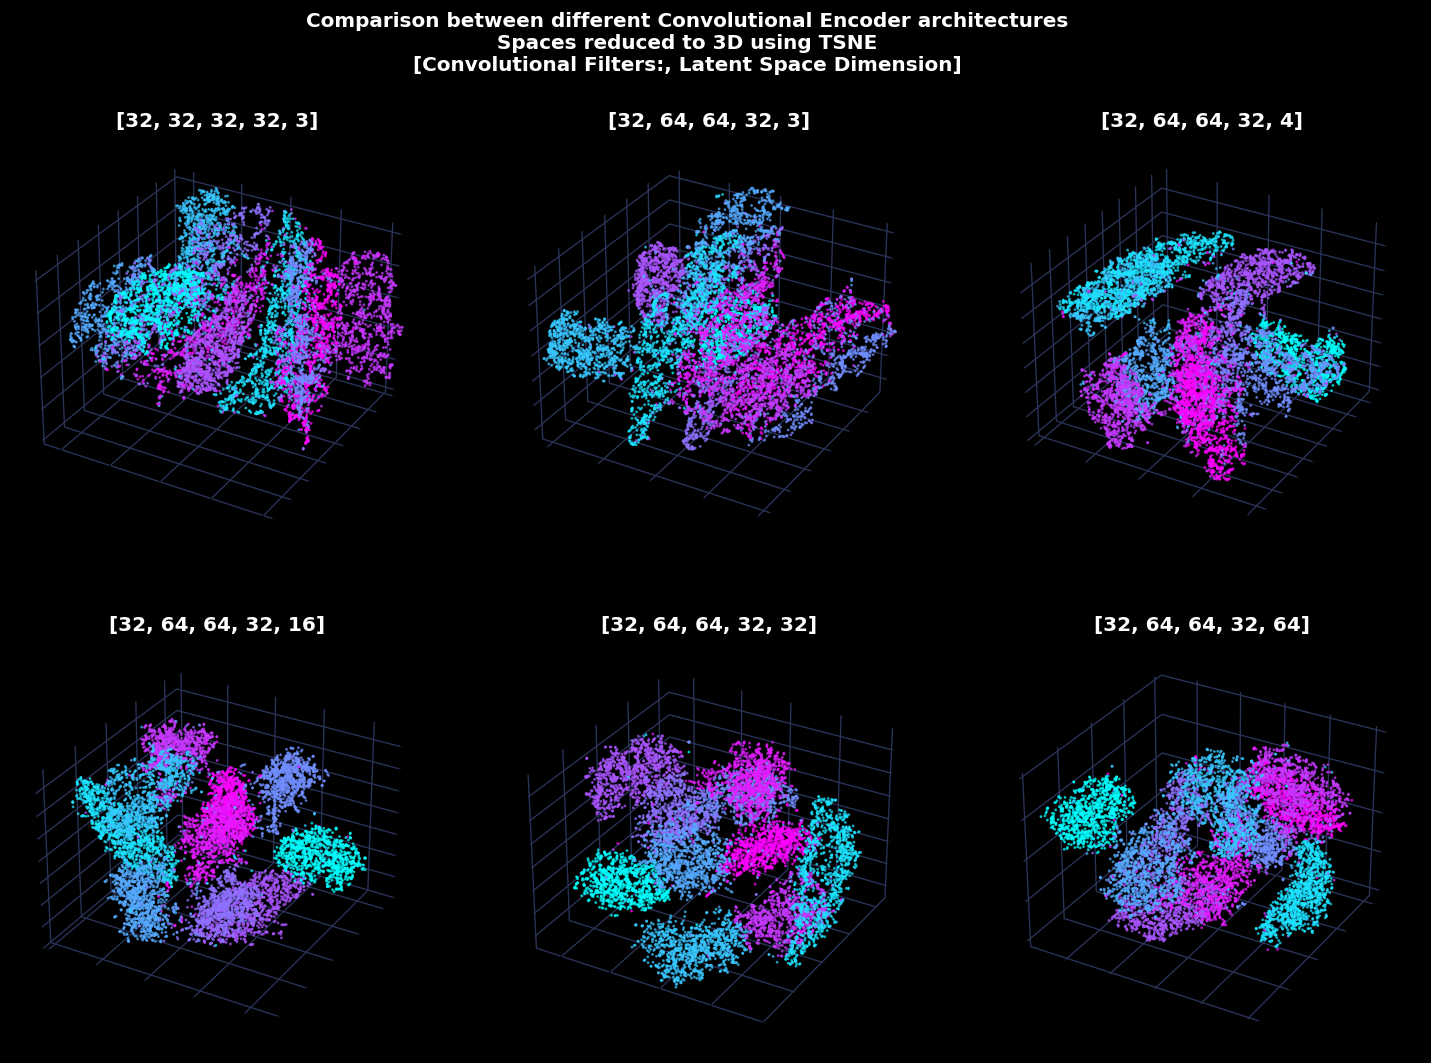

In [29]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) == 5}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'Spaces reduced to {projected_dim}D using {method}\n'
                f'[Convolutional Filters:, Latent Space Dimension]')
figure.savefig('./images/9.2_image_12.png');

In [30]:
projected_dim = 3
method = 'UMAP'
method_kwargs = {}
latent_space_dict = {
    **latent_space_dict,
    **reduce_dimensions_of_dict(
        get_dict_of_latent_spaces(
            {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
            mnist_test),
        reduced_dim=projected_dim, method=method, **method_kwargs
    )
}

100%|██████████| 40/40 [00:02<00:00, 18.36it/s]
C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 32, 32, 32, 3], time taken: 2.144 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 3], time taken: 2.025 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 4], time taken: 2.149 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 16], time taken: 2.299 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 32], time taken: 2.238 seconds.


C:\Users\thejg\Desktop\Programming\MachineLearningApplications\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced for [32, 64, 64, 32, 64], time taken: 2.248 seconds.


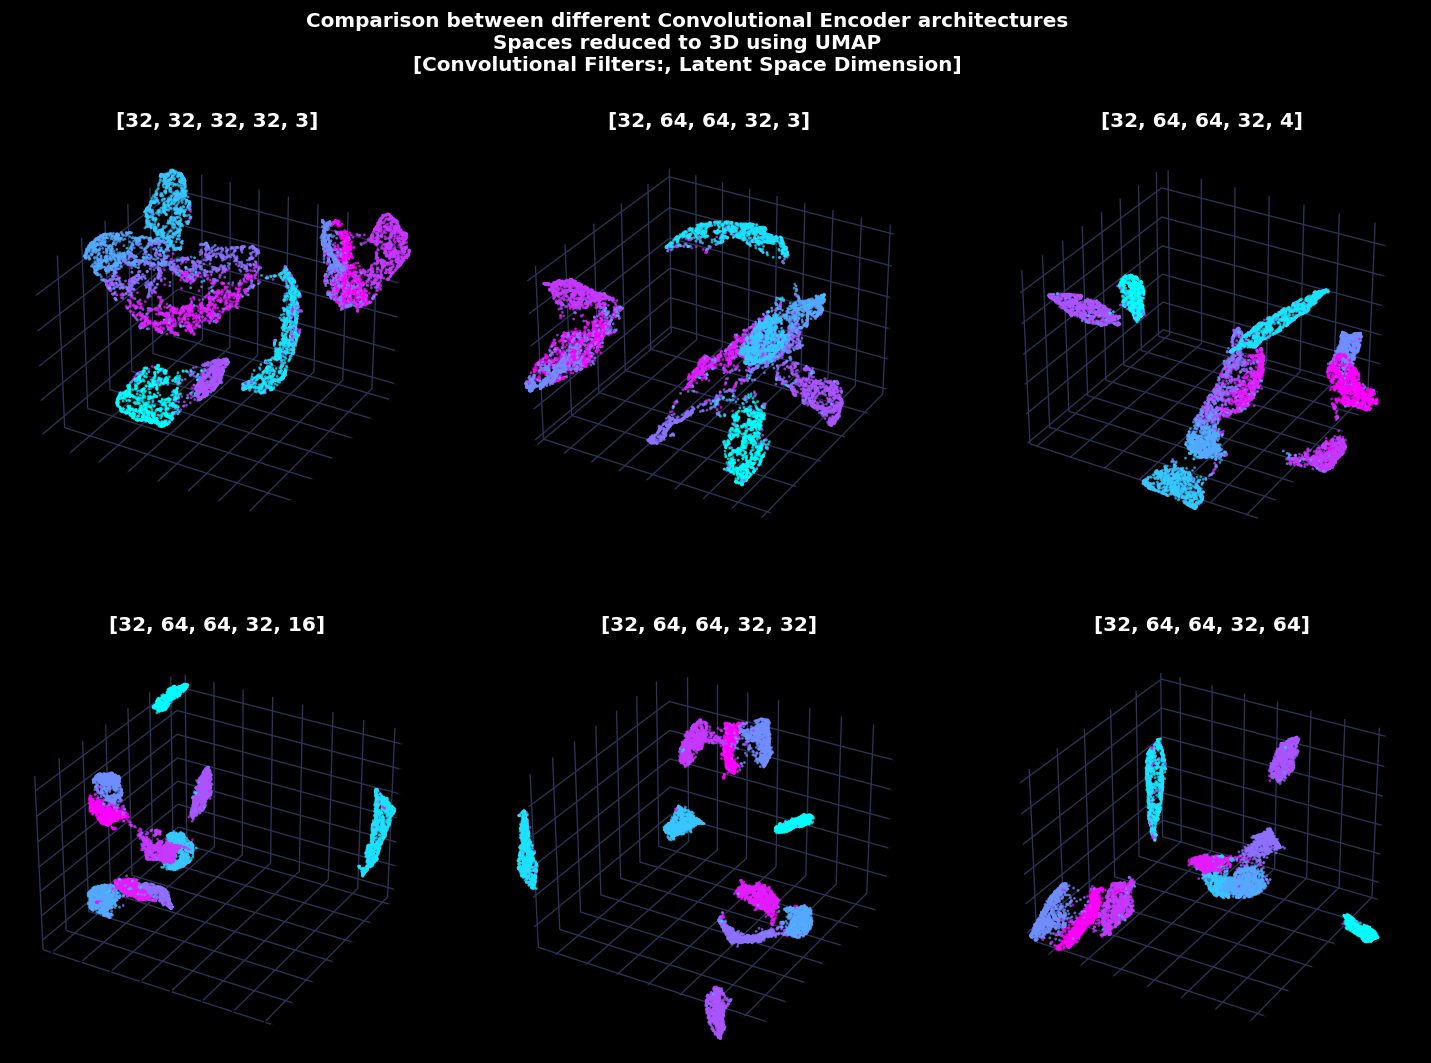

In [31]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) == 5}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'Spaces reduced to {projected_dim}D using {method}\n'
                f'[Convolutional Filters:, Latent Space Dimension]')
figure.savefig('./images/9.2_image_13.png');